In [ ]:
# avoid more than 1 element per cell

In [ ]:
import numpy as np
import random
import gym
from gym import spaces
import pygame

class WarehouseEnv(gym.Env):
    """
    Environment representing a warehouse where a robot navigates to pick up packages and deliver them to designated points.
    """

    def __init__(self, grid_size, num_packages, num_delivery_points):
        """
        Initializes the Warehouse environment.

        Parameters:
        - grid_size (int): Size of the grid layout.
        - num_packages (int): Number of packages in the warehouse.
        - num_delivery_points (int): Number of delivery points in the warehouse.
        """
        super(WarehouseEnv, self).__init__()
        self.grid_size = grid_size
        self.num_packages = num_packages
        self.num_delivery_points = num_delivery_points
        self.action_space = spaces.Discrete(6)  # Up, Down, Left, Right, Pick up, Drop off
        self.observation_space = spaces.Tuple((
            spaces.Discrete(grid_size),  # Robot X position
            spaces.Discrete(grid_size),  # Robot Y position
            spaces.MultiBinary(num_packages),  # Package locations
            spaces.MultiBinary(num_delivery_points),  # Delivery locations
            spaces.MultiBinary(num_packages)  # Inventory
        ))
        self.reset()

    def reset(self):
        """
        Resets the environment to its initial state.

        Returns:
        - observation (tuple): Initial observation of the environment.
        """
        self.robot_pos = [0, 0]
        self.packages = np.zeros(self.grid_size)
        self.delivery_points = np.zeros(self.grid_size)
        self.inventory = np.zeros(self.num_packages)

        # Randomly place at least one package without overlapping with delivery points
        placed_package = False
        while not placed_package:
            rand_x = np.random.randint(self.grid_size)
            rand_y = np.random.randint(self.grid_size)
            while self.delivery_points[rand_x] == 1:
                rand_x = np.random.randint(self.grid_size)
                rand_y = np.random.randint(self.grid_size)
            self.packages[rand_x] = 1
            placed_package = True

        # Ensure delivery points are placed without overlapping with packages
        placed_delivery = 0
        while placed_delivery < self.num_delivery_points:
            rand_x = np.random.randint(self.grid_size)
            if self.delivery_points[rand_x] == 0 and self.packages[rand_x] == 0:
                self.delivery_points[rand_x] = 1
                placed_delivery += 1

        return self._get_observation()

    def step(self, action):
        """
        Executes one time step in the environment.

        Parameters:
        - action (int): Action to be taken by the agent.

        Returns:
        - observation (tuple): New observation of the environment.
        - reward (float): Reward received from the environment.
        - done (bool): Whether the episode is done or not.
        - info (dict): Additional information about the environment.
        """
        reward = 0
        done = False
        new_pos = self.robot_pos[:]

        if action == 0:  # Move Up
            new_pos[0] -= 1
        elif action == 1:  # Move Down
            new_pos[0] += 1
        elif action == 2:  # Move Left
            new_pos[1] -= 1
        elif action == 3:  # Move Right
            new_pos[1] += 1
        elif action == 4:  # Pick up
            if tuple(self.robot_pos) in self.packages:
                package_index = list(self.robot_pos).index(1)
                self.inventory[package_index] = 1
                self.packages[package_index] = 0
                reward += 10
            else:
                reward -= 1
        elif action == 5:  # Drop off
            if tuple(self.robot_pos) in self.delivery_points:
                if 1 in self.inventory:
                    package_index = list(self.inventory).index(1)
                    self.inventory[package_index] = 0
                    reward += 100
                    # Check if all packages have been delivered
                    if np.sum(self.inventory) == 0:
                        done = True  # Episode ends if all packages are delivered
                else:
                    reward -= 10
            else:
                reward -= 10

        if 0 <= new_pos[0] < self.grid_size and 0 <= new_pos[1] < self.grid_size:
            self.robot_pos = new_pos  # Update the robot's position

        observation = self._get_observation()
        return observation, reward, done, {}

    def _get_observation(self):
        """
        Returns the current observation of the environment.

        Returns:
        - observation (tuple): Current observation of the environment.
        """
        return tuple(self.robot_pos + [int(x) for x in self.packages] + [int(x) for x in self.delivery_points] + [int(x) for x in self.inventory])

def draw_env(screen, env):
    """
    Draws the current state of the environment on the screen.

    Parameters:
    - screen (pygame.Surface): Pygame surface representing the screen.
    - env (WarehouseEnv): Instance of the Warehouse environment.
    """
    screen.fill((255, 255, 255))
    cell_size = 50
    grid_size = env.grid_size
    robot_img = pygame.image.load("robot.png").convert_alpha()
    package_img = pygame.image.load("package.png").convert_alpha()
    delivery_img = pygame.image.load("delivery.png").convert_alpha()

    for i in range(grid_size):
        pygame.draw.line(screen, (0, 0, 0), (i * cell_size, 0), (i * cell_size, grid_size * cell_size))
        pygame.draw.line(screen, (0, 0, 0), (0, i * cell_size), (grid_size * cell_size, i * cell_size))

    robot_pos = env.robot_pos
    screen.blit(robot_img, (robot_pos[1] * cell_size, robot_pos[0] * cell_size))

    for i in range(grid_size):
        for j in range(grid_size):
            if env.packages[i] == 1:
                screen.blit(package_img, (j * cell_size, i * cell_size))
            if env.delivery_points[i] == 1:
                screen.blit(delivery_img, (j * cell_size, i * cell_size))

    pygame.display.flip()

# Q-learning parameters
gamma = 0.9
alpha = 0.1

def q_learning(env, num_episodes=1000, max_steps_per_episode=3):
    """
    Performs Q-learning to train the agent.

    Parameters:
    - env (WarehouseEnv): Instance of the Warehouse environment.
    - num_episodes (int): Number of episodes for training.
    - max_steps_per_episode (int): Maximum number of steps per episode.
    """
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        done = False
        while not done and steps < max_steps_per_episode:
            action = np.argmax(q_table[state])
            next_state, reward, done, _ = env.step(action)
            q_value = q_table[state, action]
            max_next_q_value = np.max(q_table[next_state])
            new_q_value = q_value + alpha * (reward + gamma * max_next_q_value - q_value)
            q_table[state, action] = new_q_value
            total_reward += reward
            state = next_state
            steps += 1
        print(f"Episode: {episode+1}, Total Reward: {total_reward}")

def main():
    env = WarehouseEnv(grid_size=5, num_packages=3, num_delivery_points=2)

    pygame.init()
    screen = pygame.display.set_mode((env.grid_size * 50, env.grid_size * 50))
    clock = pygame.time.Clock()

    num_episodes = 1000
    max_steps_per_episode = 100  # Define maximum steps per episode
    for episode in range(num_episodes):
        print(f"Current Episode: {episode+1}")  # Print current episode
        state = env.reset()
        total_reward = 0
        done = False
        steps = 0  # Initialize step count
        exit_flag = False  # Flag to exit event handling loop
        while not done and steps < max_steps_per_episode:  # Check maximum steps condition
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    exit_flag = True  # Set the exit flag to True
                    break  # Exit the event handling loop
            if exit_flag:
                break  # Exit the episode loop if the exit flag is True
            draw_env(screen, env)
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            clock.tick(10)
            steps += 1  # Increment step count
        print(f"Episode: {episode+1}, Total Reward: {total_reward}")

    pygame.quit()

if __name__ == "__main__":
    main()


# TASK IV

In [ ]:
# α=0.5, γ= 0.5 for 2 hyper parameters. In addition, about the policy, εvalue starts at 0.9,
#and it is reduced by multiplied by 0.9999 until εvalue =0.5; then it decreases again by multiplied by 0.999 until εvalue = 0.01

In [ ]:
import numpy as np
import random
import gym
from gym import spaces
import pygame

class WarehouseEnv(gym.Env):
    """
    Environment representing a warehouse where a robot navigates to pick up packages and deliver them to designated points.
    """

    def __init__(self, grid_size, num_packages, num_delivery_points):
        """
        Initializes the Warehouse environment.

        Parameters:
        - grid_size (int): Size of the grid layout.
        - num_packages (int): Number of packages in the warehouse.
        - num_delivery_points (int): Number of delivery points in the warehouse.
        """
        super(WarehouseEnv, self).__init__()
        self.grid_size = grid_size
        self.num_packages = num_packages
        self.num_delivery_points = num_delivery_points
        self.action_space = spaces.Discrete(6)  # Up, Down, Left, Right, Pick up, Drop off
        self.observation_space = spaces.Tuple((
            spaces.Discrete(grid_size),  # Robot X position
            spaces.Discrete(grid_size),  # Robot Y position
            spaces.MultiBinary(num_packages),  # Package locations
            spaces.MultiBinary(num_delivery_points),  # Delivery locations
            spaces.MultiBinary(num_packages)  # Inventory
        ))
        self.reset()

    def reset(self):
        """
        Resets the environment to its initial state.

        Returns:
        - observation (tuple): Initial observation of the environment.
        """
        self.robot_pos = [0, 0]
        self.packages = np.zeros((self.grid_size, self.grid_size))
        self.delivery_points = np.zeros((self.grid_size, self.grid_size))
        self.obstacles = np.zeros((self.grid_size, self.grid_size))
        self.inventory = np.zeros(self.num_packages)
        self.package_to_delivery = {}  # Dictionary to store package to delivery point associations

        # Randomly place delivery points
        for _ in range(self.num_delivery_points):
            rand_x = np.random.randint(self.grid_size)
            rand_y = np.random.randint(self.grid_size)
            while self.delivery_points[rand_x][rand_y] == 1:  # Ensure unique location for each delivery point
                rand_x = np.random.randint(self.grid_size)
                rand_y = np.random.randint(self.grid_size)
            self.delivery_points[rand_x][rand_y] = 1

        # Assign packages to remaining empty locations
        placed_packages = 0
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if placed_packages < self.num_packages and self.delivery_points[i][j] == 0:
                    self.packages[i][j] = 1
                    # Find the nearest delivery point and associate the package with it
                    dist_to_delivery = np.inf
                    nearest_delivery = None
                    for di in range(self.grid_size):
                        for dj in range(self.grid_size):
                            if self.delivery_points[di][dj] == 1:
                                dist = abs(i - di) + abs(j - dj)
                                if dist < dist_to_delivery:
                                    dist_to_delivery = dist
                                    nearest_delivery = (di, dj)
                    self.package_to_delivery[(i, j)] = nearest_delivery
                    placed_packages += 1

        # Randomly place obstacles
        num_obstacles = 0
        while num_obstacles < 2:  # Add 2 obstacles per episode
            rand_x = np.random.randint(self.grid_size)
            rand_y = np.random.randint(self.grid_size)
            if (
                self.packages[rand_x][rand_y] == 0
                and self.delivery_points[rand_x][rand_y] == 0
                and self.obstacles[rand_x][rand_y] == 0
            ):
                self.obstacles[rand_x][rand_y] = 1
                num_obstacles += 1

        self.q_table = np.zeros((2 ** (self.grid_size * 2 + self.num_packages * 2), self.action_space.n))
        return self._get_observation()

    def step(self, action):
        """
        Executes one time step in the environment.

        Parameters:
        - action (int): Action to be taken by the agent.

        Returns:
        - observation (tuple): New observation of the environment.
        - reward (float): Reward received from the environment.
        - done (bool): Whether the episode is done or not.
        - info (dict): Additional information about the environment.
        """
        reward = 0
        done = False
        new_pos = self.robot_pos[:]

        if action == 0:  # Move Up
            new_pos[0] -= 1
        elif action == 1:  # Move Down
            new_pos[0] += 1
        elif action == 2:  # Move Left
            new_pos[1] -= 1
        elif action == 3:  # Move Right
            new_pos[1] += 1
        elif action == 4:  # Pick up
            if tuple(self.robot_pos) in self.packages:
                package_index = list(self.robot_pos).index(1)
                self.inventory[package_index] = 1
                self.packages[self.robot_pos[0]][self.robot_pos[1]] = 0
                reward += 10  # Add a positive reward for picking up a package
            else:
                reward -= 1
        elif action == 5:  # Drop off
            if tuple(self.robot_pos) in self.delivery_points:
                if 1 in self.inventory:
                    package_index = list(self.inventory).index(1)
                    self.inventory[package_index] = 0
                    reward += 100
                    # Check if all packages have been delivered
                    if np.sum(self.inventory) == 0:
                        done = True  # Episode ends if all packages are delivered
                else:
                    reward -= 10
            else:
                reward -= 10

        # Check if new position is within grid boundaries
        if 0 <= new_pos[0] < self.grid_size and 0 <= new_pos[1] < self.grid_size:
            # Check for collision with obstacles
            if self.obstacles[new_pos[0]][new_pos[1]] == 1:
                reward -= 5  # Negative reward for collision with obstacles
                done = True  # Episode ends if collision occurs
            else:
                # Update robot's position
                self.robot_pos = new_pos

        # Positive reward for reaching intermediate steps (packages or delivery points)
        if reward == 0:
            reward += 1

        observation = self._get_observation()
        return observation, reward, done, {}


    def _get_observation(self):
        """
        Returns the current observation of the environment.

        Returns:
        - observation (tuple): Current observation of the environment.
        """
        package_locations = [int(x) for row in self.packages for x in row]
        delivery_locations = [int(x) for row in self.delivery_points for x in row]
        obstacles = [int(x) for row in self.obstacles for x in row]
        inventory = [int(x) for x in self.inventory]
        return tuple(self.robot_pos + package_locations + delivery_locations + obstacles + inventory)

def hash_state(env, state):
    """
    Hashes the state tuple into a single integer for indexing.

    Parameters:
    - env (WarehouseEnv): Instance of the Warehouse environment.
    - state (tuple): State tuple to be hashed.

    Returns:
    - hash_value (int): Hashed value of the state.
    """
    hash_value = 0
    for i, s in enumerate(state):
        hash_value += s * (2 ** i)
    return hash_value % env.q_table.shape[0]  # Ensure the hash value is within Q-table bounds


def draw_env(screen, env):
    """
    Draws the current state of the environment on the screen.

    Parameters:
    - screen (pygame.Surface): Pygame surface representing the screen.
    - env (WarehouseEnv): Instance of the Warehouse environment.
    """
    screen.fill((255, 255, 255))
    cell_size = 50
    grid_size = env.grid_size
    robot_img = pygame.image.load("robot.png").convert_alpha()
    package_img = pygame.image.load("package.png").convert_alpha()
    delivery_img = pygame.image.load("delivery.png").convert_alpha()
    obstacle_img = pygame.image.load("warning.png").convert_alpha()  # Load obstacle image

    for i in range(grid_size):
        for j in range(grid_size):
            pygame.draw.rect(screen, (255, 255, 255), (j * cell_size, i * cell_size, cell_size, cell_size))
            pygame.draw.rect(screen, (0, 0, 0), (j * cell_size, i * cell_size, cell_size, cell_size), 1)

            if env.packages[i][j] == 1:
                screen.blit(package_img, (j * cell_size, i * cell_size))
            if env.delivery_points[i][j] == 1:
                screen.blit(delivery_img, (j * cell_size, i * cell_size))
            if env.obstacles[i][j] == 1:  # Draw obstacle if present
                screen.blit(obstacle_img, (j * cell_size, i * cell_size))

    robot_pos = env.robot_pos
    screen.blit(robot_img, (robot_pos[1] * cell_size, robot_pos[0] * cell_size))

    pygame.display.flip()


def main():
    env = WarehouseEnv(grid_size=5, num_packages=3, num_delivery_points=3)

    # Print the number of delivery points and packages
    print(f"Number of delivery points: {env.num_delivery_points}")
    print(f"Number of packages: {env.num_packages}")

    pygame.init()
    screen = pygame.display.set_mode((env.grid_size * 50, env.grid_size * 50))
    clock = pygame.time.Clock()

    num_episodes = 1000
    max_steps_per_episode = 1000  # Define maximum steps per episode
    alpha = 0.5  # Learning rate
    gamma = 0.5  # Discount factor
    epsilon = 0.9  # Initial epsilon value
    min_epsilon = 0.01  # Minimum epsilon value
    decay_rate = 0.9999  # Epsilon decay rate

    all_rewards = []

    for episode in range(num_episodes):
        print(f"Current Episode: {episode + 1}")  # Print current episode
        state = env.reset()
        total_reward = 0
        done = False
        steps = 0  # Initialize step count
        exit_flag = False  # Flag to exit event handling loop

        # Update epsilon based on decay policy
        if epsilon > min_epsilon:
            epsilon *= decay_rate
            epsilon = max(epsilon, min_epsilon)

        while not done and steps < max_steps_per_episode:  # Check maximum steps condition
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    exit_flag = True  # Set the exit flag to True
                    break  # Exit the event handling loop
            if exit_flag:
                break  # Exit the episode loop if the exit flag is True
            draw_env(screen, env)

            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()  # Choose a random action
            else:
                # Choose the greedy action based on Q-values
                hashed_state = hash_state(env, env._get_observation())
                action = np.argmax(env.q_table[hashed_state])

            next_state, reward, done, _ = env.step(action)

            # Update Q-table using Q-learning equation with specified alpha and gamma
            hashed_state = hash_state(env, state)
            next_hashed_state = hash_state(env, next_state)
            best_next_action = np.argmax(env.q_table[next_hashed_state])
            env.q_table[hashed_state][action] += alpha * (
                reward + gamma * env.q_table[next_hashed_state][best_next_action] - env.q_table[hashed_state][action]
            )

            total_reward += reward
            clock.tick(10)
            steps += 1  # Increment step count
        print(f"Episode: {episode + 1}, Total Reward: {total_reward}")
        all_rewards.append(total_reward)

    pygame.quit()

    # Print the Q matrix after training
    print("Q matrix after training:")
    print(env.q_table)

    # Calculate average rewards for each episode
    avg_rewards = np.mean(all_rewards, axis=0)

    # Plotting
    episodes = np.arange(1, num_episodes + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, avg_rewards)
    plt.title("Average Cumulative Reward per Episode")
    plt.xlabel("Episode Number")
    plt.ylabel("Average Cumulative Reward")
    plt.show()


if __name__ == "__main__":
    main()



In [ ]:
# TASK V

In [ ]:
# with obstacles

# TASK 1 TO 6

# IV

Number of delivery points: 3
Number of packages: 3
Current Episode: 1


/var/folders/nn/139b9d_s3s5bwn22mvsl_89m0000gn/T/ipykernel_66045/3754458489.py:129: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if tuple(self.robot_pos) in self.delivery_points:


Episode: 1, Total Reward: -11
Current Episode: 2


/var/folders/nn/139b9d_s3s5bwn22mvsl_89m0000gn/T/ipykernel_66045/3754458489.py:121: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if tuple(self.robot_pos) in self.packages:


Episode: 2, Total Reward: -1
Current Episode: 3
Episode: 3, Total Reward: -68
Current Episode: 4
Episode: 4, Total Reward: -90
Current Episode: 5
Episode: 5, Total Reward: -29
Current Episode: 6
Episode: 6, Total Reward: -12
Current Episode: 7
Episode: 7, Total Reward: -76
Current Episode: 8
Episode: 8, Total Reward: -83
Current Episode: 9
Episode: 9, Total Reward: -17
Current Episode: 10
Episode: 10, Total Reward: -57
Current Episode: 11
Episode: 11, Total Reward: -156
Current Episode: 12
Episode: 12, Total Reward: -23
Current Episode: 13
Episode: 13, Total Reward: -3
Current Episode: 14
Episode: 14, Total Reward: -20
Current Episode: 15
Episode: 15, Total Reward: -53
Current Episode: 16
Episode: 16, Total Reward: -5
Current Episode: 17
Episode: 17, Total Reward: -73
Current Episode: 18
Episode: 18, Total Reward: -6
Current Episode: 19
Episode: 19, Total Reward: -103
Current Episode: 20
Episode: 20, Total Reward: -53
Current Episode: 21
Episode: 21, Total Reward: -117
Current Episode:

Episode: 161, Total Reward: -1
Current Episode: 162
Episode: 162, Total Reward: -623
Current Episode: 163
Episode: 163, Total Reward: -80
Current Episode: 164
Episode: 164, Total Reward: -56
Current Episode: 165
Episode: 165, Total Reward: -183
Current Episode: 166
Episode: 166, Total Reward: -70
Current Episode: 167
Episode: 167, Total Reward: -2
Current Episode: 168
Episode: 168, Total Reward: -94
Current Episode: 169
Episode: 169, Total Reward: -53
Current Episode: 170
Episode: 170, Total Reward: -6
Current Episode: 171
Episode: 171, Total Reward: -26
Current Episode: 172
Episode: 172, Total Reward: -77
Current Episode: 173
Episode: 173, Total Reward: -2
Current Episode: 174
Episode: 174, Total Reward: -367
Current Episode: 175
Episode: 175, Total Reward: -154
Current Episode: 176
Episode: 176, Total Reward: -35
Current Episode: 177
Episode: 177, Total Reward: -177
Current Episode: 178
Episode: 178, Total Reward: -73
Current Episode: 179
Episode: 179, Total Reward: -29
Current Episo

Episode: 316, Total Reward: -81
Current Episode: 317
Episode: 317, Total Reward: -78
Current Episode: 318
Episode: 318, Total Reward: -12
Current Episode: 319
Episode: 319, Total Reward: -110
Current Episode: 320
Episode: 320, Total Reward: -84
Current Episode: 321
Episode: 321, Total Reward: -893
Current Episode: 322
Episode: 322, Total Reward: -21
Current Episode: 323
Episode: 323, Total Reward: -29
Current Episode: 324
Episode: 324, Total Reward: -8
Current Episode: 325
Episode: 325, Total Reward: -85
Current Episode: 326
Episode: 326, Total Reward: -152
Current Episode: 327
Episode: 327, Total Reward: -19
Current Episode: 328
Episode: 328, Total Reward: -56
Current Episode: 329
Episode: 329, Total Reward: -28
Current Episode: 330
Episode: 330, Total Reward: -1
Current Episode: 331
Episode: 331, Total Reward: -54
Current Episode: 332
Episode: 332, Total Reward: -14
Current Episode: 333
Episode: 333, Total Reward: -17
Current Episode: 334
Episode: 334, Total Reward: -36
Current Episo

Episode: 471, Total Reward: -3
Current Episode: 472
Episode: 472, Total Reward: -58
Current Episode: 473
Episode: 473, Total Reward: -68
Current Episode: 474
Episode: 474, Total Reward: -10
Current Episode: 475
Episode: 475, Total Reward: 1
Current Episode: 476
Episode: 476, Total Reward: -12
Current Episode: 477
Episode: 477, Total Reward: -47
Current Episode: 478
Episode: 478, Total Reward: -63
Current Episode: 479
Episode: 479, Total Reward: 6
Current Episode: 480
Episode: 480, Total Reward: -3
Current Episode: 481
Episode: 481, Total Reward: -176
Current Episode: 482
Episode: 482, Total Reward: -129
Current Episode: 483
Episode: 483, Total Reward: -3
Current Episode: 484
Episode: 484, Total Reward: -16
Current Episode: 485
Episode: 485, Total Reward: -80
Current Episode: 486
Episode: 486, Total Reward: -24
Current Episode: 487
Episode: 487, Total Reward: -57
Current Episode: 488
Episode: 488, Total Reward: -40
Current Episode: 489
Episode: 489, Total Reward: -22
Current Episode: 49

Episode: 626, Total Reward: -22
Current Episode: 627
Episode: 627, Total Reward: -1
Current Episode: 628
Episode: 628, Total Reward: -33
Current Episode: 629
Episode: 629, Total Reward: -191
Current Episode: 630
Episode: 630, Total Reward: -180
Current Episode: 631
Episode: 631, Total Reward: -62
Current Episode: 632
Episode: 632, Total Reward: -149
Current Episode: 633
Episode: 633, Total Reward: -37
Current Episode: 634
Episode: 634, Total Reward: -20
Current Episode: 635
Episode: 635, Total Reward: -31
Current Episode: 636
Episode: 636, Total Reward: -96
Current Episode: 637
Episode: 637, Total Reward: -58
Current Episode: 638
Episode: 638, Total Reward: -7
Current Episode: 639
Episode: 639, Total Reward: -38
Current Episode: 640
Episode: 640, Total Reward: -42
Current Episode: 641
Episode: 641, Total Reward: -2
Current Episode: 642
Episode: 642, Total Reward: -4
Current Episode: 643
Episode: 643, Total Reward: -16
Current Episode: 644
Episode: 644, Total Reward: -26
Current Episode

Episode: 781, Total Reward: -14
Current Episode: 782
Episode: 782, Total Reward: -34
Current Episode: 783
Episode: 783, Total Reward: -17
Current Episode: 784
Episode: 784, Total Reward: -5
Current Episode: 785
Episode: 785, Total Reward: -5
Current Episode: 786
Episode: 786, Total Reward: -96
Current Episode: 787
Episode: 787, Total Reward: -15
Current Episode: 788
Episode: 788, Total Reward: -11
Current Episode: 789
Episode: 789, Total Reward: -31
Current Episode: 790
Episode: 790, Total Reward: 0
Current Episode: 791
Episode: 791, Total Reward: -73
Current Episode: 792
Episode: 792, Total Reward: -648
Current Episode: 793
Episode: 793, Total Reward: -855
Current Episode: 794
Episode: 794, Total Reward: -128
Current Episode: 795
Episode: 795, Total Reward: -42
Current Episode: 796
Episode: 796, Total Reward: -78
Current Episode: 797
Episode: 797, Total Reward: -127
Current Episode: 798
Episode: 798, Total Reward: -33
Current Episode: 799
Episode: 799, Total Reward: -3
Current Episode

Episode: 936, Total Reward: -415
Current Episode: 937
Episode: 937, Total Reward: -34
Current Episode: 938
Episode: 938, Total Reward: -127
Current Episode: 939
Episode: 939, Total Reward: -13
Current Episode: 940
Episode: 940, Total Reward: -68
Current Episode: 941
Episode: 941, Total Reward: -20
Current Episode: 942
Episode: 942, Total Reward: -30
Current Episode: 943
Episode: 943, Total Reward: -36
Current Episode: 944
Episode: 944, Total Reward: -22
Current Episode: 945
Episode: 945, Total Reward: -275
Current Episode: 946
Episode: 946, Total Reward: -271
Current Episode: 947
Episode: 947, Total Reward: -246
Current Episode: 948
Episode: 948, Total Reward: -32
Current Episode: 949
Episode: 949, Total Reward: -155
Current Episode: 950
Episode: 950, Total Reward: -144
Current Episode: 951
Episode: 951, Total Reward: -6
Current Episode: 952
Episode: 952, Total Reward: -24
Current Episode: 953
Episode: 953, Total Reward: -17
Current Episode: 954
Episode: 954, Total Reward: -69
Current 

ValueError: x and y must have same first dimension, but have shapes (1000,) and (1,)

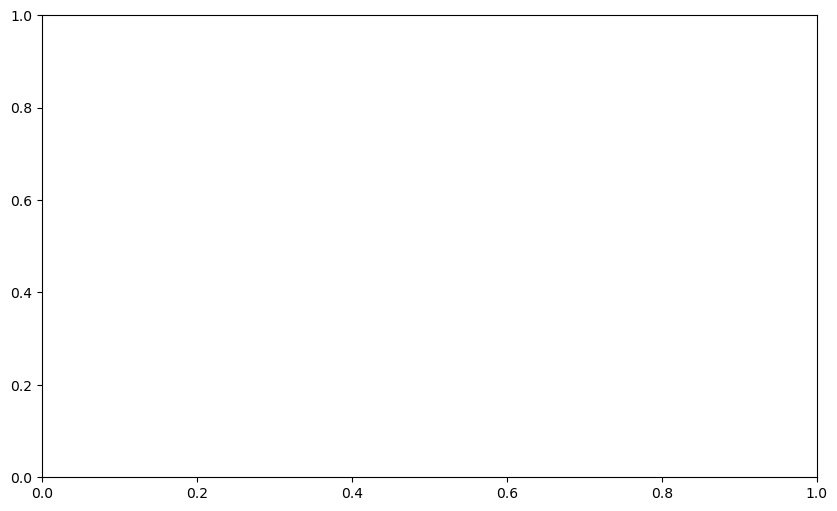

In [1]:
import numpy as np
import random
import gym
from gym import spaces
import pygame
import seaborn as sns
import matplotlib.pyplot as plt

class WarehouseEnv(gym.Env):
    """
    Environment representing a warehouse where a robot navigates to pick up packages and deliver them to designated points.
    """

    def __init__(self, grid_size, num_packages, num_delivery_points):
        """
        Initializes the Warehouse environment.

        Parameters:
        - grid_size (int): Size of the grid layout.
        - num_packages (int): Number of packages in the warehouse.
        - num_delivery_points (int): Number of delivery points in the warehouse.
        """
        super(WarehouseEnv, self).__init__()
        self.grid_size = grid_size
        self.num_packages = num_packages
        self.num_delivery_points = num_delivery_points
        self.action_space = spaces.Discrete(6)  # Up, Down, Left, Right, Pick up, Drop off
        self.observation_space = spaces.Tuple((
            spaces.Discrete(grid_size),  # Robot X position
            spaces.Discrete(grid_size),  # Robot Y position
            spaces.MultiBinary(num_packages),  # Package locations
            spaces.MultiBinary(num_delivery_points),  # Delivery locations
            spaces.MultiBinary(num_packages)  # Inventory
        ))
        self.reset()

    def reset(self):
        """
        Resets the environment to its initial state.

        Returns:
        - observation (tuple): Initial observation of the environment.
        """
        self.robot_pos = [0, 0]
        self.packages = np.zeros((self.grid_size, self.grid_size))
        self.delivery_points = np.zeros((self.grid_size, self.grid_size))
        self.obstacles = np.zeros((self.grid_size, self.grid_size))
        self.inventory = np.zeros(self.num_packages)
        self.package_to_delivery = {}  # Dictionary to store package to delivery point associations

        # Randomly place delivery points
        for _ in range(self.num_delivery_points):
            rand_x = np.random.randint(self.grid_size)
            rand_y = np.random.randint(self.grid_size)
            while self.delivery_points[rand_x][rand_y] == 1:  # Ensure unique location for each delivery point
                rand_x = np.random.randint(self.grid_size)
                rand_y = np.random.randint(self.grid_size)
            self.delivery_points[rand_x][rand_y] = 1

        # Assign packages to remaining empty locations
        placed_packages = 0
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if placed_packages < self.num_packages and self.delivery_points[i][j] == 0:
                    self.packages[i][j] = 1
                    # Find the nearest delivery point and associate the package with it
                    dist_to_delivery = np.inf
                    nearest_delivery = None
                    for di in range(self.grid_size):
                        for dj in range(self.grid_size):
                            if self.delivery_points[di][dj] == 1:
                                dist = abs(i - di) + abs(j - dj)
                                if dist < dist_to_delivery:
                                    dist_to_delivery = dist
                                    nearest_delivery = (di, dj)
                    self.package_to_delivery[(i, j)] = nearest_delivery
                    placed_packages += 1

        # Randomly place obstacles
        num_obstacles = 0
        while num_obstacles < 2:  # Add 2 obstacles per episode
            rand_x = np.random.randint(self.grid_size)
            rand_y = np.random.randint(self.grid_size)
            if (
                self.packages[rand_x][rand_y] == 0
                and self.delivery_points[rand_x][rand_y] == 0
                and self.obstacles[rand_x][rand_y] == 0
            ):
                self.obstacles[rand_x][rand_y] = 1
                num_obstacles += 1

        self.q_table = np.zeros((2 ** (self.grid_size * 2 + self.num_packages * 2), self.action_space.n))
        return self._get_observation()

    def step(self, action):
        """
        Executes one time step in the environment.

        Parameters:
        - action (int): Action to be taken by the agent.

        Returns:
        - observation (tuple): New observation of the environment.
        - reward (float): Reward received from the environment.
        - done (bool): Whether the episode is done or not.
        - info (dict): Additional information about the environment.
        """
        reward = 0
        done = False
        new_pos = self.robot_pos[:]

        if action == 0:  # Move Up
            new_pos[0] -= 1
        elif action == 1:  # Move Down
            new_pos[0] += 1
        elif action == 2:  # Move Left
            new_pos[1] -= 1
        elif action == 3:  # Move Right
            new_pos[1] += 1
        elif action == 4:  # Pick up
            if tuple(self.robot_pos) in self.packages:
                package_index = list(self.robot_pos).index(1)
                self.inventory[package_index] = 1
                self.packages[self.robot_pos[0]][self.robot_pos[1]] = 0
                reward += 10  # Add a positive reward for picking up a package
            else:
                reward -= 1
        elif action == 5:  # Drop off
            if tuple(self.robot_pos) in self.delivery_points:
                if 1 in self.inventory:
                    package_index = list(self.inventory).index(1)
                    self.inventory[package_index] = 0
                    reward += 100
                    # Check if all packages have been delivered
                    if np.sum(self.inventory) == 0:
                        done = True  # Episode ends if all packages are delivered
                else:
                    reward -= 10
            else:
                reward -= 10

        # Check if new position is within grid boundaries
        if 0 <= new_pos[0] < self.grid_size and 0 <= new_pos[1] < self.grid_size:
            # Check for collision with obstacles
            if self.obstacles[new_pos[0]][new_pos[1]] == 1:
                reward -= 5  # Negative reward for collision with obstacles
                done = True  # Episode ends if collision occurs
            else:
                # Update robot's position
                self.robot_pos = new_pos

        # Positive reward for reaching intermediate steps (packages or delivery points)
        if reward == 0:
            reward += 1

        observation = self._get_observation()
        return observation, reward, done, {}


    def _get_observation(self):
        """
        Returns the current observation of the environment.

        Returns:
        - observation (tuple): Current observation of the environment.
        """
        package_locations = [int(x) for row in self.packages for x in row]
        delivery_locations = [int(x) for row in self.delivery_points for x in row]
        obstacles = [int(x) for row in self.obstacles for x in row]
        inventory = [int(x) for x in self.inventory]
        return tuple(self.robot_pos + package_locations + delivery_locations + obstacles + inventory)

def hash_state(env, state):
    """
    Hashes the state tuple into a single integer for indexing.

    Parameters:
    - env (WarehouseEnv): Instance of the Warehouse environment.
    - state (tuple): State tuple to be hashed.

    Returns:
    - hash_value (int): Hashed value of the state.
    """
    hash_value = 0
    for i, s in enumerate(state):
        hash_value += s * (2 ** i)
    return hash_value % env.q_table.shape[0]  # Ensure the hash value is within Q-table bounds


def draw_env(screen, env):
    """
    Draws the current state of the environment on the screen.

    Parameters:
    - screen (pygame.Surface): Pygame surface representing the screen.
    - env (WarehouseEnv): Instance of the Warehouse environment.
    """
    screen.fill((255, 255, 255))
    cell_size = 50
    grid_size = env.grid_size
    robot_img = pygame.image.load("robot.png").convert_alpha()
    package_img = pygame.image.load("package.png").convert_alpha()
    delivery_img = pygame.image.load("delivery.png").convert_alpha()
    obstacle_img = pygame.image.load("warning.png").convert_alpha()  # Load obstacle image

    for i in range(grid_size):
        for j in range(grid_size):
            pygame.draw.rect(screen, (255, 255, 255), (j * cell_size, i * cell_size, cell_size, cell_size))
            pygame.draw.rect(screen, (0, 0, 0), (j * cell_size, i * cell_size, cell_size, cell_size), 1)

            if env.packages[i][j] == 1:
                screen.blit(package_img, (j * cell_size, i * cell_size))
            if env.delivery_points[i][j] == 1:
                screen.blit(delivery_img, (j * cell_size, i * cell_size))
            if env.obstacles[i][j] == 1:  # Draw obstacle if present
                screen.blit(obstacle_img, (j * cell_size, i * cell_size))

    robot_pos = env.robot_pos
    screen.blit(robot_img, (robot_pos[1] * cell_size, robot_pos[0] * cell_size))

    pygame.display.flip()
    
def main():
    env = WarehouseEnv(grid_size=5, num_packages=3, num_delivery_points=3)

    # Print the number of delivery points and packages
    print(f"Number of delivery points: {env.num_delivery_points}")
    print(f"Number of packages: {env.num_packages}")

    pygame.init()
    screen = pygame.display.set_mode((env.grid_size * 50, env.grid_size * 50))
    clock = pygame.time.Clock()

    num_episodes = 1000
    max_steps_per_episode = 1000  # Define maximum steps per episode
    alpha = 0.5  # Learning rate
    gamma = 0.5  # Discount factor
    epsilon = 0.9  # Initial epsilon value
    min_epsilon = 0.01  # Minimum epsilon value
    decay_rate = 0.9999  # Epsilon decay rate

    all_rewards = []

    for episode in range(num_episodes):
        print(f"Current Episode: {episode + 1}")  # Print current episode
        state = env.reset()
        total_reward = 0
        done = False
        steps = 0  # Initialize step count
        exit_flag = False  # Flag to exit event handling loop

        # Update epsilon based on decay policy
        if epsilon > min_epsilon:
            epsilon *= decay_rate
            epsilon = max(epsilon, min_epsilon)

        while not done and steps < max_steps_per_episode:  # Check maximum steps condition
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    exit_flag = True  # Set the exit flag to True
                    break  # Exit the event handling loop
            if exit_flag:
                break  # Exit the episode loop if the exit flag is True
            draw_env(screen, env)

            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()  # Choose a random action
            else:
                # Choose the greedy action based on Q-values
                hashed_state = hash_state(env, env._get_observation())
                action = np.argmax(env.q_table[hashed_state])

            next_state, reward, done, _ = env.step(action)

            # Update Q-table using Q-learning equation with specified alpha and gamma
            hashed_state = hash_state(env, state)
            next_hashed_state = hash_state(env, next_state)
            best_next_action = np.argmax(env.q_table[next_hashed_state])
            env.q_table[hashed_state][action] += alpha * (
                reward + gamma * env.q_table[next_hashed_state][best_next_action] - env.q_table[hashed_state][action]
            )

            total_reward += reward
            clock.tick(10)
            steps += 1  # Increment step count
        print(f"Episode: {episode + 1}, Total Reward: {total_reward}")
        all_rewards.append(total_reward)

    pygame.quit()



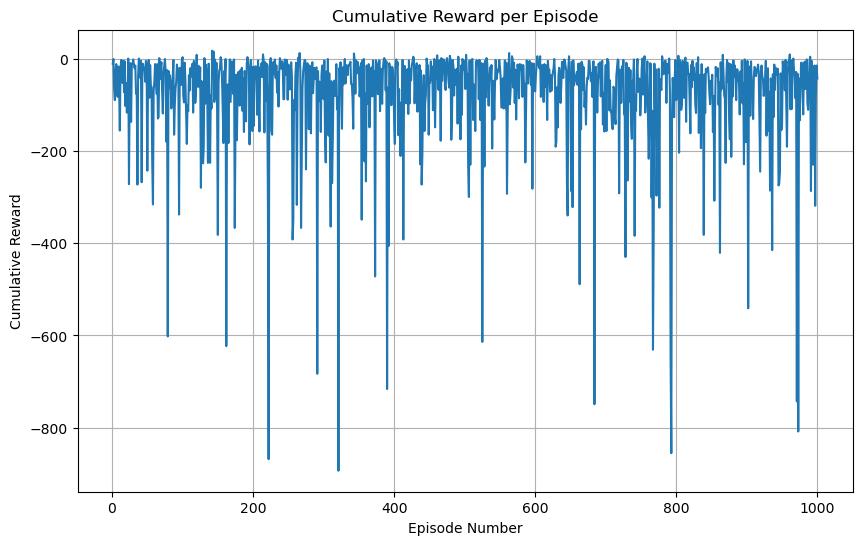

In [4]:
import matplotlib.pyplot as plt

# Provided cumulative rewards data
cumulative_rewards = [
    -11, -1, -68, -90, -29, -12, -76, -83, -17, -57, -156, -23, -3, -20, -53, -5, -73, -6, -103, -53,
    -117, -79, 0, -272, -58, -10, -137, -14, -12, -2, -13, -21, -15, -76, -74, -273, -35, 0, -6, -42,
    -5, -268, -11, -12, -23, -24, -50, -5, -13, -243, -51, -3, -85, -14, -59, -61, -227, -316, -69,
    -51, -12, -43, -76, -12, -130, -127, 1, -44, -19, -8, -70, -119, -36, -16, -1, -29, -180, -25,
    -602, -27, -64, -36, -50, -108, -77, -38, -3, -165, -99, -65, -50, -13, -32, -22, -338, -20,
    -24, -57, -5, 3, -81, -95, -9, -48, -114, -185, -101, -114, -36, -69, -21, -39, -20, -11, -117,
    -5, -13, -96, -75, 8, -61, -53, -16, -62, -19, -280, -49, -64, -227, -192, 1, -98, -13, -31,
    -81, -226, -11, -98, -226, -79, -108, 17, -5, 15, -94, -2, -86, -9, -111, -382,-52, -26, -22, 3, -5, -47, -120, -183, -27, -38, -1, -623, -80, -56, -183, -70, -2, -94, -53,
    -6, -26, -77, -2, -367, -154, -35, -177, -73, -29, -41, -102, -25, -62, -20, -113, -42, -159,
    -27, -60, -136, -11, 3, -5, -26, -186, -36, -3, -101, -157, -18, -146, -32, -17, -17, -48,
    -122, -4, -80, -158, -19, -39, -10, -40, 9, -4, -160, -8, -92, -11, -65, -305, -868, -17,
    -11, 1, -156, -165, -12, -7, -34, -2, -42, -15, -74, -29, -104, -30, 1, -12, -22, -6, -11,
    -88, -88, -2, -35, -34, -3, -89, -13, -19, -67, -38, -8, -37, -392, -349, -90, -112, -36,
    -9, -317, -63, 2, -5, 12, -28, -367, -211, -63, -28, -14, -3, -4, -240, -38, -10, -25, -153,
    -15, -31, -162, -30, -8, -75, -44, -20, -44, -22, -19, -683, -27, -92, -50, -54, -159, -35,
    -15, -15, -88,-4, -171, -225, -28, -108, -1, -167, -32, -181, -364, -49, -270, -176, -56, -48, -81, -78, -12, -110,
    -84, -893, -21, -29, -8, -85, -152, -19, -56, -28, -1, -54, -14, -17, -36, -15, -13, -13, -7, -55, -56,
    -86, -152, 11, -4, -76, -4, -32, -7, -15, -20, -82, -58, -10, -349, -4, -18, -1, -223, -76, -266, -15,
    -98, -31, -12, -149, -83, -39, -19, -82, -4, -64, -28, -472, -4, -8, -14, -77, -49, -4, -114, -22, -59,
    -98, -24, -5, 1, -3, -69, -6, -716, -63, -406, -10, -18, -31, -101, -18, -21, -43, -139, -185, -15, -2,
    -18, -8, -166, -66, -158, -211, -95, -155, -3, -392, -61, -16, -28, -97, -60, -23, -120, -4, -97, -23,
    -47, -15, -7, 4, 1, -97, -43, -23, -10, -115, -38, -58, -14, -229, -26, -273, -210, -72, -36, -157, -96,
    -79, 0, -14, -15, -165, -47, -52, -6, -45, -17, -112, -56, -1, -149, -51, -23, 7, -38, -68, -4, -43,
    -178, 1, -48, -16, -2, -3, -58, -68, -10, 1, -12, -47, -63, 6, -3, -176, -129, -3, -16, -80, -24,
    -57, -40, -22, -141, 4, -102, -33, -175, -15, -122, -1, -24, -5, -13,-66, 8, -31, -33, -236, -300, -4, 
    -230, -22, -2, -1, -133, -56, -59, -157, -8, -4, -14, -5, -88, -3, -133, -93, -10, -614, -164, -11, 
    -234, -5, -84, 1, -9, -61, -102, -49, -19, -46, -14, -195, -48, -62, -132, -53, -3, -45, -34, -24, 
    -28, -3, -18, -41, -106, -74, -43, -108, -48, -4, -108, -9, -293, -121, -31, 12, -99, -73, -37, 5, 0, 
    -63, -9, -96, -24, -132, -50, -13, -25, -86, -12, -18, -13, -28, -83, -14, -52, -54, -225, -119, -4, 
    -29, -54, -14, -5, -20, -57, -10, -282, -20, -11, -64, -71, -35, -16, 5, -14, -14, -21, 5, -83, -57, 
    -14, -61, -94, -12, -61, -14, -49, -133, -5, -30, -24, -72, -36, -70, -42, -30, -22, -1, -33, -191, 
    -180, -62, -149, -37, -20, -31, -96, -58, -7, -38, -42, -2, -4, -16, -26, -271, -340, -20, 5, -40, -52, 
    -287, -7, -322, -4, -58, -51, -43, -36, -29, -57, -11, -17, -489, -10, -153, -7, -14, -68, -19, -105, 
    -72, -143, -60, -41, -44, -5, -5, -29, -49, -32, -83, -7, -6, -749, -68, -18, -68, -117, -52, -11, -39, 
    -8, -82, -38, -5, -143, -74, -158, -67, -14, -157, -1, -2, -8, -112, -47, -115, -113, -149, -153, -61,
    -67, -128, -142, -39, -20, -2, -4, -292, -24, -37, -96, -17, -39, -3, -121, -123, -430, -9, -12, -264, 
    -58, -20, -93, -25, -142, -174, -49, -45, -2, -384, -79, -113, -27, -1, -72, -43, -44, -123, -84,-21, 0, -78, -13, 5, -117, -83, -51, -6, -131, -217, -123, -10, -12, -301, 
    -113, -631, -379, -11, -118, -23, -297, -171, -240, -22, -323, -44, -61, -68, 
    5, -14, -34, -17, -5, -5, -96, -15, -11, -31, 0, -73, -648, -855, -128, -42, 
    -78, -127, -33, -3, -90, -28, -73, 6, -204, -3, -21, -111, -99, -5, -42, -85, 
    -10, 2, -137, -9, -9, -34, -33, -90, -162, -14, -62, -5, -46, -19, -36, -99, 
    -118, -10, -48, 3, -161, -66, -35, -194, -12, -86, -67, -382, -34, -118, -22, 
    -25, -29, -19, -41, -76, -99, -48, -74, -35, -159, -81, -308, -120, -18, -34, 
    -38, -21, -100, -51, -421, -8, -67, -50, 8, -32, -79, -88, -226, -45, -3, -50, 
    -10, -132, -175, -12, -213, -32, -82, -4, -40, -15, -41, -90, -23, -24, -45, 
    -53, -121, -28, -90, -5, -97, -54, -229, -2, -83, -181, -35, -5, -541, -17, 
    -28, -124, -6, -52, -53, -131, -41, -18, -21, -38, -27, -24, -13, -34, -134, 
    -245, -25, -15, -38, -45, -81, -68, -47, -5, -167, -59, -21, -157, -72, -286, 
    -43, -70, -415, -34, -127, -13, -68, -20, -30, -36, -22, -275, -271, -246, -32, 
    -155, -144, -6, -24, -17, -69, -3, -101, -191, -39, -6, -10, 9, -110, -4, -109, 
    -16, 0, -26, -39, -86, -29, -743, -33, -808, -43, -134, -68, -9, -9, -53, -121, 
    -22, -7, -66, -29, -2, -96, -111, -47, -5, 4, -287, -5, -34, -230, -95, -15, -319, 
    -79, -15, -43]


# Plotting
episodes = range(1, len(cumulative_rewards) + 1)
plt.figure(figsize=(10, 6))
plt.plot(episodes, cumulative_rewards)
plt.title("Cumulative Reward per Episode")
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.show()


# V

In [ ]:
import numpy as np
import random
import gym
from gym import spaces
import pygame
import seaborn as sns
import matplotlib.pyplot as plt

class WarehouseEnv(gym.Env):
    """
    Environment representing a warehouse where a robot navigates to pick up packages and deliver them to designated points.
    """

    def __init__(self, grid_size, num_packages, num_delivery_points):
        """
        Initializes the Warehouse environment.

        Parameters:
        - grid_size (int): Size of the grid layout.
        - num_packages (int): Number of packages in the warehouse.
        - num_delivery_points (int): Number of delivery points in the warehouse.
        """
        super(WarehouseEnv, self).__init__()
        self.grid_size = grid_size
        self.num_packages = num_packages
        self.num_delivery_points = num_delivery_points
        self.action_space = spaces.Discrete(6)  # Up, Down, Left, Right, Pick up, Drop off
        self.observation_space = spaces.Tuple((
            spaces.Discrete(grid_size),  # Robot X position
            spaces.Discrete(grid_size),  # Robot Y position
            spaces.MultiBinary(num_packages),  # Package locations
            spaces.MultiBinary(num_delivery_points),  # Delivery locations
            spaces.MultiBinary(num_packages)  # Inventory
        ))
        self.reset()

    def reset(self):
        """
        Resets the environment to its initial state.

        Returns:
        - observation (tuple): Initial observation of the environment.
        """
        self.robot_pos = [0, 0]
        self.packages = np.zeros((self.grid_size, self.grid_size))
        self.delivery_points = np.zeros((self.grid_size, self.grid_size))
        self.obstacles = np.zeros((self.grid_size, self.grid_size))
        self.inventory = np.zeros(self.num_packages)
        self.package_to_delivery = {}  # Dictionary to store package to delivery point associations

        # Randomly place delivery points
        for _ in range(self.num_delivery_points):
            rand_x = np.random.randint(self.grid_size)
            rand_y = np.random.randint(self.grid_size)
            while self.delivery_points[rand_x][rand_y] == 1:  # Ensure unique location for each delivery point
                rand_x = np.random.randint(self.grid_size)
                rand_y = np.random.randint(self.grid_size)
            self.delivery_points[rand_x][rand_y] = 1

        # Assign packages to remaining empty locations
        placed_packages = 0
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if placed_packages < self.num_packages and self.delivery_points[i][j] == 0:
                    self.packages[i][j] = 1
                    # Find the nearest delivery point and associate the package with it
                    dist_to_delivery = np.inf
                    nearest_delivery = None
                    for di in range(self.grid_size):
                        for dj in range(self.grid_size):
                            if self.delivery_points[di][dj] == 1:
                                dist = abs(i - di) + abs(j - dj)
                                if dist < dist_to_delivery:
                                    dist_to_delivery = dist
                                    nearest_delivery = (di, dj)
                    self.package_to_delivery[(i, j)] = nearest_delivery
                    placed_packages += 1

        # Randomly place obstacles
        num_obstacles = 0
        while num_obstacles < 2:  # Add 2 obstacles per episode
            rand_x = np.random.randint(self.grid_size)
            rand_y = np.random.randint(self.grid_size)
            if (
                self.packages[rand_x][rand_y] == 0
                and self.delivery_points[rand_x][rand_y] == 0
                and self.obstacles[rand_x][rand_y] == 0
            ):
                self.obstacles[rand_x][rand_y] = 1
                num_obstacles += 1

        self.q_table = np.zeros((2 ** (self.grid_size * 2 + self.num_packages * 2), self.action_space.n))
        return self._get_observation()

    def step(self, action):
        """
        Executes one time step in the environment.

        Parameters:
        - action (int): Action to be taken by the agent.

        Returns:
        - observation (tuple): New observation of the environment.
        - reward (float): Reward received from the environment.
        - done (bool): Whether the episode is done or not.
        - info (dict): Additional information about the environment.
        """
        reward = 0
        done = False
        new_pos = self.robot_pos[:]

        if action == 0:  # Move Up
            new_pos[0] -= 1
        elif action == 1:  # Move Down
            new_pos[0] += 1
        elif action == 2:  # Move Left
            new_pos[1] -= 1
        elif action == 3:  # Move Right
            new_pos[1] += 1
        elif action == 4:  # Pick up
            if tuple(self.robot_pos) in self.packages:
                package_index = list(self.robot_pos).index(1)
                self.inventory[package_index] = 1
                self.packages[self.robot_pos[0]][self.robot_pos[1]] = 0
                reward += 10  # Add a positive reward for picking up a package
            else:
                reward -= 1
        elif action == 5:  # Drop off
            if tuple(self.robot_pos) in self.delivery_points:
                if 1 in self.inventory:
                    package_index = list(self.inventory).index(1)
                    self.inventory[package_index] = 0
                    reward += 100
                    # Check if all packages have been delivered
                    if np.sum(self.inventory) == 0:
                        done = True  # Episode ends if all packages are delivered
                else:
                    reward -= 10
            else:
                reward -= 10

        # Check if new position is within grid boundaries
        if 0 <= new_pos[0] < self.grid_size and 0 <= new_pos[1] < self.grid_size:
            # Check for collision with obstacles
            if self.obstacles[new_pos[0]][new_pos[1]] == 1:
                reward -= 5  # Negative reward for collision with obstacles
                done = True  # Episode ends if collision occurs
            else:
                # Update robot's position
                self.robot_pos = new_pos

        # Positive reward for reaching intermediate steps (packages or delivery points)
        if reward == 0:
            reward += 1

        observation = self._get_observation()
        return observation, reward, done, {}


    def _get_observation(self):
        """
        Returns the current observation of the environment.

        Returns:
        - observation (tuple): Current observation of the environment.
        """
        package_locations = [int(x) for row in self.packages for x in row]
        delivery_locations = [int(x) for row in self.delivery_points for x in row]
        obstacles = [int(x) for row in self.obstacles for x in row]
        inventory = [int(x) for x in self.inventory]
        return tuple(self.robot_pos + package_locations + delivery_locations + obstacles + inventory)

def hash_state(env, state):
    """
    Hashes the state tuple into a single integer for indexing.

    Parameters:
    - env (WarehouseEnv): Instance of the Warehouse environment.
    - state (tuple): State tuple to be hashed.

    Returns:
    - hash_value (int): Hashed value of the state.
    """
    hash_value = 0
    for i, s in enumerate(state):
        hash_value += s * (2 ** i)
    return hash_value % env.q_table.shape[0]  # Ensure the hash value is within Q-table bounds


def draw_env(screen, env):
    """
    Draws the current state of the environment on the screen.

    Parameters:
    - screen (pygame.Surface): Pygame surface representing the screen.
    - env (WarehouseEnv): Instance of the Warehouse environment.
    """
    screen.fill((255, 255, 255))
    cell_size = 50
    grid_size = env.grid_size
    robot_img = pygame.image.load("robot.png").convert_alpha()
    package_img = pygame.image.load("package.png").convert_alpha()
    delivery_img = pygame.image.load("delivery.png").convert_alpha()
    obstacle_img = pygame.image.load("warning.png").convert_alpha()  # Load obstacle image

    for i in range(grid_size):
        for j in range(grid_size):
            pygame.draw.rect(screen, (255, 255, 255), (j * cell_size, i * cell_size, cell_size, cell_size))
            pygame.draw.rect(screen, (0, 0, 0), (j * cell_size, i * cell_size, cell_size, cell_size), 1)

            if env.packages[i][j] == 1:
                screen.blit(package_img, (j * cell_size, i * cell_size))
            if env.delivery_points[i][j] == 1:
                screen.blit(delivery_img, (j * cell_size, i * cell_size))
            if env.obstacles[i][j] == 1:  # Draw obstacle if present
                screen.blit(obstacle_img, (j * cell_size, i * cell_size))

    robot_pos = env.robot_pos
    screen.blit(robot_img, (robot_pos[1] * cell_size, robot_pos[0] * cell_size))

    pygame.display.flip()
    
def main():
    env = WarehouseEnv(grid_size=5, num_packages=1, num_delivery_points=1)

    # Print the number of delivery points and packages
    print(f"Number of delivery points: {env.num_delivery_points}")
    print(f"Number of packages: {env.num_packages}")

    # Initialize Pygame
    pygame.init()
    # Create a Pygame display screen
    # screen = pygame.display.set_mode((env.grid_size * 50, env.grid_size * 50))
    clock = pygame.time.Clock()

    num_episodes = 700
    max_steps_per_episode = 500  # Define maximum steps per episode
    epsilon = 0.2  # Define epsilon value for epsilon-greedy strategy
    alphas = [0.9, 0.1, 0.5]  # Different alpha values to try
    gammas = [0.9, 0.5, 0.2]  # Different gamma values to try

    for gamma in gammas:
        print(f"Testing Gamma: {gamma}")
        discount_factor = gamma  # Set the discount factor to the current gamma value
        for alpha in alphas:
            print(f"Testing Alpha: {alpha}")
            learning_rate = alpha  # Set the learning rate to the current alpha value
            total_rewards = []  # Store total rewards for each episode
            for episode in range(num_episodes):
                print(f"Current Episode: {episode+1}")  # Print current episode
                state = env.reset()
                total_reward = 0
                done = False
                steps = 0  # Initialize step count
                while not done and steps < max_steps_per_episode:  # Check maximum steps condition
                    # draw_env(screen, env)  # Commented out Pygame drawing

                    current_state = env._get_observation()
                    hashed_state = hash_state(env, current_state)
                    if random.random() < epsilon:
                        action = env.action_space.sample()  # Choose a random action
                    else:
                        action = np.argmax(env.q_table[hashed_state])

                    next_state, reward, done, _ = env.step(action)
                    total_reward += reward

                    next_hashed_state = hash_state(env, next_state)
                    best_next_action = np.argmax(env.q_table[next_hashed_state])

                    # Update Q-table
                    env.q_table[hashed_state][action] += learning_rate * (
                        reward + discount_factor * env.q_table[next_hashed_state][best_next_action] - env.q_table[hashed_state][action])

                    clock.tick(10)
                    steps += 1  # Increment step count
                print(f"Episode: {episode+1}, Total Reward: {total_reward}")
                total_rewards.append(total_reward)  # Append total reward for this episode

            # Plot total rewards for this alpha and gamma value
            plt.plot(range(1, num_episodes + 1), total_rewards, label=f"Alpha: {alpha}, Gamma: {gamma}")

    plt.xlabel("Episode Number")
    plt.ylabel("Total Reward")
    plt.title("Total Reward per Episode for Different Alpha and Gamma Values")
    plt.legend()
    plt.show()

    pygame.quit()

if __name__ == "__main__":
    main()


Number of delivery points: 1
Number of packages: 1
Testing Gamma: 0.9
Testing Alpha: 0.9
Current Episode: 1


/var/folders/nn/139b9d_s3s5bwn22mvsl_89m0000gn/T/ipykernel_69733/727966372.py:129: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if tuple(self.robot_pos) in self.delivery_points:
/var/folders/nn/139b9d_s3s5bwn22mvsl_89m0000gn/T/ipykernel_69733/727966372.py:121: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if tuple(self.robot_pos) in self.packages:


Episode: 1, Total Reward: 65
Current Episode: 2
Episode: 2, Total Reward: 1
Current Episode: 3
Episode: 3, Total Reward: 229
Current Episode: 4
Episode: 4, Total Reward: 93
Current Episode: 5
Episode: 5, Total Reward: 279
Current Episode: 6
Episode: 6, Total Reward: 13
Current Episode: 7
Episode: 7, Total Reward: 97
Current Episode: 8
Episode: 8, Total Reward: 307
Current Episode: 9
Episode: 9, Total Reward: 293
Current Episode: 10
Episode: 10, Total Reward: 326
Current Episode: 11
Episode: 11, Total Reward: -5
Current Episode: 12
Episode: 12, Total Reward: 276
Current Episode: 13
Episode: 13, Total Reward: 96
Current Episode: 14
Episode: 14, Total Reward: 25
Current Episode: 15
Episode: 15, Total Reward: 59
Current Episode: 16
Episode: 16, Total Reward: 394
Current Episode: 17
Episode: 17, Total Reward: -28
Current Episode: 18
Episode: 18, Total Reward: 0
Current Episode: 19
Episode: 19, Total Reward: -27
Current Episode: 20
Episode: 20, Total Reward: 8
Current Episode: 21
Episode: 21

Episode: 162, Total Reward: 169
Current Episode: 163
Episode: 163, Total Reward: 290
Current Episode: 164
Episode: 164, Total Reward: 23
Current Episode: 165
Episode: 165, Total Reward: 161
Current Episode: 166
Episode: 166, Total Reward: 118
Current Episode: 167
Episode: 167, Total Reward: 220
Current Episode: 168
Episode: 168, Total Reward: 189
Current Episode: 169
Episode: 169, Total Reward: 80
Current Episode: 170
Episode: 170, Total Reward: 287
Current Episode: 171
Episode: 171, Total Reward: 342
Current Episode: 172
Episode: 172, Total Reward: 272
Current Episode: 173
Episode: 173, Total Reward: 310
Current Episode: 174
Episode: 174, Total Reward: -3
Current Episode: 175
Episode: 175, Total Reward: 16
Current Episode: 176
Episode: 176, Total Reward: 6
Current Episode: 177
Episode: 177, Total Reward: 310
Current Episode: 178
Episode: 178, Total Reward: 232
Current Episode: 179
Episode: 179, Total Reward: -5
Current Episode: 180
Episode: 180, Total Reward: 172
Current Episode: 181


Episode: 318, Total Reward: 25
Current Episode: 319
Episode: 319, Total Reward: 30
Current Episode: 320
Episode: 320, Total Reward: 319
Current Episode: 321
Episode: 321, Total Reward: 295
Current Episode: 322
Episode: 322, Total Reward: 218
Current Episode: 323
Episode: 323, Total Reward: 270
Current Episode: 324
Episode: 324, Total Reward: 258
Current Episode: 325
Episode: 325, Total Reward: 269
Current Episode: 326
Episode: 326, Total Reward: -4
Current Episode: 327
Episode: 327, Total Reward: 36
Current Episode: 328
Episode: 328, Total Reward: 228
Current Episode: 329
Episode: 329, Total Reward: 210
Current Episode: 330
Episode: 330, Total Reward: 275
Current Episode: 331
Episode: 331, Total Reward: 300
Current Episode: 332
Episode: 332, Total Reward: 162
Current Episode: 333
Episode: 333, Total Reward: 328
Current Episode: 334
Episode: 334, Total Reward: -1
Current Episode: 335
Episode: 335, Total Reward: 285
Current Episode: 336
Episode: 336, Total Reward: 244
Current Episode: 33

Episode: 474, Total Reward: 296
Current Episode: 475
Episode: 475, Total Reward: 336
Current Episode: 476
Episode: 476, Total Reward: 231
Current Episode: 477
Episode: 477, Total Reward: 324
Current Episode: 478
Episode: 478, Total Reward: 10
Current Episode: 479
Episode: 479, Total Reward: 61
Current Episode: 480
Episode: 480, Total Reward: 330
Current Episode: 481
Episode: 481, Total Reward: 6
Current Episode: 482
Episode: 482, Total Reward: 228
Current Episode: 483
Episode: 483, Total Reward: 15
Current Episode: 484
Episode: 484, Total Reward: 314
Current Episode: 485
Episode: 485, Total Reward: 25
Current Episode: 486
Episode: 486, Total Reward: 38
Current Episode: 487
Episode: 487, Total Reward: -2
Current Episode: 488
Episode: 488, Total Reward: 0
Current Episode: 489
Episode: 489, Total Reward: 52
Current Episode: 490
Episode: 490, Total Reward: 313
Current Episode: 491
Episode: 491, Total Reward: 124
Current Episode: 492
Episode: 492, Total Reward: 333
Current Episode: 493
Epis

Episode: 630, Total Reward: 120
Current Episode: 631
Episode: 631, Total Reward: 31
Current Episode: 632
Episode: 632, Total Reward: 46
Current Episode: 633
Episode: 633, Total Reward: 321
Current Episode: 634
Episode: 634, Total Reward: 321
Current Episode: 635
Episode: 635, Total Reward: 258
Current Episode: 636
Episode: 636, Total Reward: 279
Current Episode: 637
Episode: 637, Total Reward: 311
Current Episode: 638
Episode: 638, Total Reward: 21
Current Episode: 639
Episode: 639, Total Reward: 305
Current Episode: 640
Episode: 640, Total Reward: -2
Current Episode: 641
Episode: 641, Total Reward: 0
Current Episode: 642
Episode: 642, Total Reward: -2
Current Episode: 643
Episode: 643, Total Reward: 171
Current Episode: 644
Episode: 644, Total Reward: 236
Current Episode: 645
Episode: 645, Total Reward: 39
Current Episode: 646
Episode: 646, Total Reward: 377
Current Episode: 647
Episode: 647, Total Reward: 203
Current Episode: 648
Episode: 648, Total Reward: 4
Current Episode: 649
Epi

Episode: 90, Total Reward: 249
Current Episode: 91
Episode: 91, Total Reward: 334
Current Episode: 92
Episode: 92, Total Reward: 28
Current Episode: 93
Episode: 93, Total Reward: 10
Current Episode: 94
Episode: 94, Total Reward: 250
Current Episode: 95
Episode: 95, Total Reward: 368
Current Episode: 96
Episode: 96, Total Reward: 258
Current Episode: 97
Episode: 97, Total Reward: 118
Current Episode: 98
Episode: 98, Total Reward: 262
Current Episode: 99
Episode: 99, Total Reward: 325
Current Episode: 100
Episode: 100, Total Reward: 295
Current Episode: 101
Episode: 101, Total Reward: -4
Current Episode: 102
Episode: 102, Total Reward: 251
Current Episode: 103
Episode: 103, Total Reward: 11
Current Episode: 104
Episode: 104, Total Reward: 329
Current Episode: 105
Episode: 105, Total Reward: 1
Current Episode: 106
Episode: 106, Total Reward: 26
Current Episode: 107
Episode: 107, Total Reward: 310
Current Episode: 108
Episode: 108, Total Reward: 219
Current Episode: 109
Episode: 109, Total

# TASK 7 AND 8

In [ ]:
#Motivation: Target Networks: Target Networks are used to stabilize training in Deep Q-Learning. By maintaining a separate target network with fixed parameters for estimating Q-values, we reduce the risk of divergence during training. This improvement helps in achieving more stable and reliable learning.
#Double DQN: Double DQN addresses the overestimation bias in traditional Q-learning algorithms. By decoupling the action selection and evaluation steps, Double DQN leads to more accurate Q-value estimations, resulting in improved learning performance.

In [ ]:
# without improvement

In [ ]:
import numpy as np
import pygame
import time
import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear


class DeepQNetwork:


    def __init__(self, action_space, state_space, learning_rate=0.001):

        self.epsilon = 1.0
        self.gamma = .95
        self.batch_size = 64
        self.epsilon_min = .01
        self.learning_rate = learning_rate
        self.epsilon_decay = .90
        self.memory = deque(maxlen=100000)
        self.action_space_size = action_space
        self.state_space_shape = state_space
        self.model = self.build_model()

    def build_model(self):

        model = Sequential()
        model.add(Dense(20, input_dim=self.state_space_shape, activation=relu))
        model.add(Dense(25, activation=relu))
        model.add(Dense(self.action_space_size, activation=linear))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def rememberFunction(self, state, action, reward, nextState, done):
        self.memory.append((state, action, reward, nextState, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space_size)
        state = np.expand_dims(state, axis=0)
        actValues = self.model.predict(state)
        return np.argmax(actValues[0])

    def replayFunction(self):

        if len(self.memory) < self.batch_size:
            return

        miniBatchVar = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in miniBatchVar])
        actions = np.array([i[1] for i in miniBatchVar])
        rewards = np.array([i[2] for i in miniBatchVar])
        nextStates = np.array([i[3] for i in miniBatchVar])
        dones = np.array([i[4] for i in miniBatchVar])

        states = np.squeeze(states)
        nextStates = np.squeeze(nextStates)

        targets = rewards + self.gamma * (np.amax(self.model.predict_on_batch(nextStates), axis=1)) * (1 - dones)
        targetsFull = self.model.predict_on_batch(states)

        indexes = np.array([i for i in range(self.batch_size)])
        targetsFull[[indexes], [actions]] = targets

        self.model.fit(states, targetsFull, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def rewardFunction(nextStateInfo):
    nextState = nextStateInfo[0]  # Extracting the nextState array
    if nextState[0] >= 0.5:
        print("Reached Goal")
        return 10
    if nextState[0] > -0.4:
        return (1 + nextState[0]) ** 2
    return 0


def trainDQNetwork(environment, agent, episode):
    episodeScores = []
    for e in range(episode):
        state = environment.reset()[0]  # Extracting the state array
        score = 0
        maxSteps = 1000
        for i in range(maxSteps):
            environment.render()
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()
            state = np.array(state)  # Convert state tuple to numpy array
            action = agent.act(state)
            stepResult = environment.step(action)  # get all return values
            nextState, reward, done = stepResult[:3]  # get the first three elements
            reward = rewardFunction(stepResult)  # pass values to rewardFunction function
            score += reward
            nextState = np.array(nextState)  
            agent.rememberFunction(state, action, reward, nextState, done)
            state = nextState
            agent.replayFunction()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        episodeScores.append(score)
    return episodeScores

def main():
    pygame.init()  # initialize Pygame
    environment = gym.make('MountainCar-v0', render_mode="human") # render as human
    np.random.seed(10)  # numpy random seed

    print(environment.observation_space)
    print(environment.action_space)
    agent = DeepQNetwork(environment.action_space.n, environment.observation_space.shape[0], learning_rate=0.001)
    episodes = 100
    episodeScores = trainDQNetwork(environment, agent, episodes)
    plt.plot([i+1 for i in range(episodes)], episodeScores)
    plt.show()

if __name__ == '__main__':
    main()


In [ ]:
# with double DQN

In [ ]:
import numpy as np
import pygame
import time
import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear


class DeepQNetwork:


    def __init__(self, action_space, state_space, learning_rate=0.001):
        # initialize Deep Q-Network parameters
        self.epsilon = 1.0
        self.gamma = .95
        self.batch_size = 64
        self.epsilon_min = .01
        self.learning_rate = learning_rate
        self.epsilon_decay = .90
        self.memory = deque(maxlen=100000)
        self.action_space_size = action_space
        self.state_space_shape = state_space
        self.model = self.build_model()
        self.target_model = self.build_model()  # Add target network

    def build_model(self):
        # build the neural network model
        model = Sequential()
        model.add(Dense(20, input_dim=self.state_space_shape, activation=relu))
        model.add(Dense(25, activation=relu))
        model.add(Dense(self.action_space_size, activation=linear))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def rememberFunction(self, state, action, reward, nextState, done):
        # remember the experience (state, action, reward, next_state, done)
        self.memory.append((state, action, reward, nextState, done))

    def act(self, state):
        # choose an action based on epsilon-greedy policy
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space_size)
        state = np.expand_dims(state, axis=0)
        actValues = self.model.predict(state)
        return np.argmax(actValues[0])

    def replayFunction(self):
        # experience replay to train the model
        if len(self.memory) < self.batch_size:
            return

        miniBatchVar = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in miniBatchVar])
        actions = np.array([i[1] for i in miniBatchVar])
        rewards = np.array([i[2] for i in miniBatchVar])
        nextStates = np.array([i[3] for i in miniBatchVar])
        dones = np.array([i[4] for i in miniBatchVar])

        states = np.squeeze(states)
        nextStates = np.squeeze(nextStates)

        # Double DQN: Use target network to select best actions
        q_values_next = self.target_model.predict_on_batch(nextStates)
        actions_next = np.argmax(self.model.predict_on_batch(nextStates), axis=1)
        targets = rewards + self.gamma * q_values_next[np.arange(self.batch_size), actions_next] * (1 - dones)

        targetsFull = self.model.predict_on_batch(states)

        indexes = np.array([i for i in range(self.batch_size)])
        targetsFull[[indexes], [actions]] = targets

        self.model.fit(states, targetsFull, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        # Update target network weights
        self.target_model.set_weights(self.model.get_weights())

def rewardFunction(nextStateInfo):
    # define the reward function based on the next state
    nextState = nextStateInfo[0]  # extracting the nextState array
    if nextState[0] >= 0.5:
        print("Car reached the top")
        return 10
    if nextState[0] > -0.4:
        return (1 + nextState[0]) ** 2
    return 0


def trainDQNetwork(environment, agent, episode):
    # Training the Deep Q-Network
    episodeScores = []
    for e in range(episode):
        state = environment.reset()[0]  # extracting the state array
        score = 0
        maxSteps = 1000
        for i in range(maxSteps):
            environment.render()
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()
            state = np.array(state)  
            action = agent.act(state)
            stepResult = environment.step(action)  # get all return values
            nextState, reward, done = stepResult[:3]  # get the first three elements
            reward = rewardFunction(stepResult)  # pass values to rewardFunction function
            score += reward
            nextState = np.array(nextState)  
            agent.rememberFunction(state, action, reward, nextState, done)
            state = nextState
            agent.replayFunction()
            if done:
                print("Episode: {}/{}, score: {}".format(e, episode, score))
                break
        episodeScores.append(score)
        agent.update_target_model()  # Update target network
    return episodeScores

def main():
    pygame.init()  # initialize Pygame
    environment = gym.make('MountainCar-v0', render_mode="human") # render as human
    np.random.seed(10)  # numpy random seed

    print(environment.observation_space)
    print(environment.action_space)
    agent = DeepQNetwork(environment.action_space.n, environment.observation_space.shape[0], learning_rate=0.001)
    episodes = 100
    episodeScores = trainDQNetwork(environment, agent, episodes)
    plt.plot([i+1 for i in range(episodes)], episodeScores)
    plt.show()

if __name__ == '__main__':
    main()


In [ ]:
#target networks

In [ ]:
import numpy as np
import pygame
import time
import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear


class DeepQNetwork:
    def __init__(self, action_space, state_space, learning_rate=0.001):
        self.epsilon = 1.0
        self.gamma = 0.95
        self.batch_size = 64
        self.epsilon_min = 0.01
        self.learning_rate = learning_rate
        self.epsilon_decay = 0.995
        self.memory = deque(maxlen=100000)
        self.action_space_size = action_space
        self.state_space_shape = state_space
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

    def build_model(self):
        model = Sequential()
        model.add(Dense(20, input_dim=self.state_space_shape, activation=relu))
        model.add(Dense(25, activation=relu))
        model.add(Dense(self.action_space_size, activation=linear))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def rememberFunction(self, state, action, reward, nextState, done):
        self.memory.append((state, action, reward, nextState, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space_size)
        state = np.expand_dims(state, axis=0)
        actValues = self.model.predict(state)
        return np.argmax(actValues[0])

    def replayFunction(self):
        if len(self.memory) < self.batch_size:
            return
        miniBatchVar = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in miniBatchVar])
        actions = np.array([i[1] for i in miniBatchVar])
        rewards = np.array([i[2] for i in miniBatchVar])
        nextStates = np.array([i[3] for i in miniBatchVar])
        dones = np.array([i[4] for i in miniBatchVar])

        states = np.squeeze(states)
        nextStates = np.squeeze(nextStates)

        targets = rewards + self.gamma * (np.amax(self.target_model.predict_on_batch(nextStates), axis=1)) * (1 - dones)
        targetsFull = self.model.predict_on_batch(states)

        indexes = np.array([i for i in range(self.batch_size)])
        targetsFull[[indexes], [actions]] = targets

        self.model.fit(states, targetsFull, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def soft_update_target_network(self, tau):
        model_weights = self.model.get_weights()
        target_model_weights = self.target_model.get_weights()

        new_weights = []
        for model_weight, target_model_weight in zip(model_weights, target_model_weights):
            new_weight = tau * model_weight + (1 - tau) * target_model_weight
            new_weights.append(new_weight)

        self.target_model.set_weights(new_weights)



def rewardFunction(nextStateInfo):
    nextState = nextStateInfo[0]  # Extracting the nextState array
    if nextState[0] >= 0.5:
        print("Reached Goal")
        return 10
    if nextState[0] > -0.4:
        return (1 + nextState[0]) ** 2
    return 0


def trainDQNetwork(environment, agent, episode):
    episodeScores = []
    for e in range(episode):
        state = environment.reset()[0]  # Extracting the state array
        score = 0
        maxSteps = 1000
        for i in range(maxSteps):
            environment.render()
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()
            state = np.array(state)  # Convert state tuple to numpy array
            action = agent.act(state)
            stepResult = environment.step(action)  # get all return values
            nextState, reward, done = stepResult[:3]  # get the first three elements
            reward = rewardFunction(stepResult)  # pass values to rewardFunction function
            score += reward
            nextState = np.array(nextState)
            agent.rememberFunction(state, action, reward, nextState, done)
            state = nextState
            agent.replayFunction()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        episodeScores.append(score)
        agent.soft_update_target_network(0.01)  # Soft update the target network
    return episodeScores


def main():
    pygame.init()  # initialize Pygame
    environment = gym.make('MountainCar-v0', render_mode="human")  # render as human
    np.random.seed(10)  # numpy random seed

    print(environment.observation_space)
    print(environment.action_space)
    agent = DeepQNetwork(environment.action_space.n, environment.observation_space.shape[0], learning_rate=0.001)
    episodes = 100
    episodeScores = trainDQNetwork(environment, agent, episodes)
    plt.plot([i + 1 for i in range(episodes)], episodeScores)
    plt.show()


if __name__ == '__main__':
    main()
